# Agent Learning Using TD(0) 

Consider an agent **A** which is using MCTS and neural network *N* to find the
best move.

This algorithm works as follows: play *M* games, recording new state, previous state, the decision, expected reward and the reward after each move (in the expert memory).

In the training loop, sample *k* moves from the memory (experience replay), compute the loss between *N(s)* and expected reward and update the params of the network.

In [1]:
config = {
    "algorithm": "TD(0)-just-state",
    "network": "Dense_board",  # name of the network to use
    "name": "dense-not-follow-state-only",  # wandb run name
    
    # about MCTS
    "stochastic": False,  # the only option now is deterministic
    "time_limit": 100,  # milliseconds
    "simuls_limit": 5000, # per move
    
    "seed": 0, # not used yet
    "optimizer": "Adam",  # not implemented yet
    # optimizer params...
    
    "test_seed": 42,  # used for always measuring performance on the same games
    "test_games": 10,
    "n_simulated_games": 20,
    "batch_size": 128,
    "n_training_loops": 64, # per one RL epoch
    "discount_factor": 0.95,
    "n_epochs": 500,

    # loss function calculation
    "alpha": 0.7,
    "beta": 0.99,
    "gamma": 0.01
}

In [2]:
%load_ext autoreload
%autoreload 2

%pip install -Uq pip
%pip install install --quiet 'git+https://github.com/balgot/mathematico.git#egg=mathematico&subdirectory=game'
%pip install -q torch torchview torch-summary graphviz
%pip install -q tqdm
%pip install -q wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

import mathematico
from src.utils import mcts

import random
import statistics

from tqdm.notebook import trange, tqdm

# disable cuda for now
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# check if cuda is available
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Neural Network Definition

As the input, the network takes `list[list[int]]` - the board and the card number of type `int`, and it approximates the value function `V(s) = V((board, card))`.

All inputs are one-hot encoded.

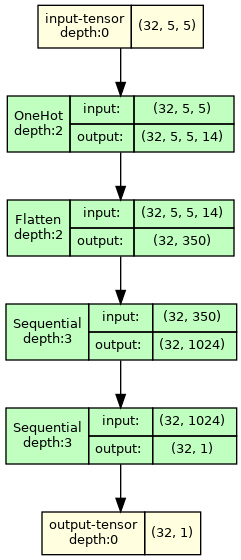

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─OneHot: 2-1                       [-1, 1, 5, 5, 14]         --
|    └─Flatten: 2-2                      [-1, 350]                 --
|    └─DenseBlock: 2-3                   [-1, 1024]                --
|    |    └─Sequential: 3-1              [-1, 1024]                361,472
|    └─DenseBlock: 2-4                   [-1, 1]                   --
|    |    └─Sequential: 3-2              [-1, 1]                   656,385
Total params: 1,017,857
Trainable params: 1,017,857
Non-trainable params: 0
Total mult-adds (M): 4.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.88
Estimated Total Size (MB): 3.89


In [3]:
from torchview import draw_graph
# VS code fix for cropped images from torchview
import graphviz
graphviz.set_jupyter_format('png')
from torchsummary import summary

# create the network
import src.nets as nets
_nn_cls = getattr(nets, config["network"])
model = _nn_cls()  # .to(dev)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters())

# create fake input for testing the net and displaying the info
_board = [[0, 1, 11, 12, 13]] * 5  # 5x5 board of ints
_card = 13
_batch_size = 32
_board_batch = torch.tensor([_board] * _batch_size)
_card_batch = torch.tensor([_card] * _batch_size)

# run the network to check it works
## model.forward(_board_batch, _card_batch)
model.forward(_board_batch)

# display the model architecture
## display(draw_graph(model, input_data=(_board_batch, _card_batch), depth=3).visual_graph)
display(draw_graph(model, input_data=_board_batch, depth=3).visual_graph)

# get the summary of the model
## summary(model, [(1, 5, 5), (1, )]);
summary(model, [(1, 5, 5)]);

### Weight & Biases Initialisation

In [4]:
import wandb
wandb.init(config=config, project="PA026", name=config.get("name", None))

wandb: Currently logged in as: 485135 (miba). Use `wandb login --relogin` to force relogin


### Agent

In [5]:
from src.agents.mcts_player import MctsPlayer, CardState, MoveState

In [6]:
def policy(state: mcts.StateI) -> float:
    # if isinstance(state, CardState):
    #     board = state.board
    # elif isinstance(state, MoveState):
    #     board = state.board
    board = torch.tensor([state.board.grid])
    # todo: actually go all the way down
    return model(board)


agent = MctsPlayer(max_time_ms=config["time_limit"], max_simulations=config["simuls_limit"], policy=policy)

In [7]:
%%time

# check it works by playing a random game
random.seed(0)
arena = mathematico.Arena()
arena.add_player(agent)
arena.run(seed=0, rounds=3, verbose=True)

Steps run: 3	Elapsed time: 7.609665155410767
CPU times: user 29.9 s, sys: 160 ms, total: 30.1 s
Wall time: 7.61 s


[[80, 50, 100]]

In [8]:
from src.utils.symmetries import all_symmetries
from src.utils.extract_data import extract


# all_symmetries(agent.mcts.root.state.board.grid)
extract(agent.mcts.root)

[([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.2922]], grad_fn=<DivBackward0>),
  83,
  0,
  0),
 ([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.0012]], grad_fn=<DivBackward0>),
  4,
  1,
  0),
 ([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.0012]], grad_fn=<DivBackward0>),
  4,
  1,
  0),
 ([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.3784]], grad_fn=<DivBackward0>),
  8,
  1,
  0),
 ([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.0063]], grad_fn=<DivBackward0>),
  4,
  1,
  0),
 ([[10, 4, 12, 1, 2],
   [9, 11, 9, 2, 3],
   [13, 13, 4, 1, 5],
   [6, 9, 10, 10, 8],
   [11, 8, 4, 2, 12]],
  tensor([[0.0012]], grad_fn=

### TD(0)

#### Utils

In [9]:
from copy import deepcopy


def _eval_against_random_player(agent, model, rounds):
    model.eval()
    wins = 0
    for _round in trange(rounds):
        game = mathematico.Mathematico(seed=_round)
        agent.reset()
        game.add_player(agent)
        game.add_player(mathematico.RandomPlayer())
        scores = game.play()
        if scores[0] >= scores[1]:
            wins += 1
    print(f"Against random player: {wins / rounds :.2%}")
    return wins / rounds


def learn_episode(agent: MctsPlayer, model: nn.Module, n_games, batch_size, m_training):
    expert_memory = []
    
    _scores = []

    # playing phase
    model.eval()
    for game in trange(n_games, desc="Game playing phase", leave=None, position=1):
        # initialize the game
        agent.reset()
        cards = [i for i in range(1, 13+1) for _ in range(4)]
        random.shuffle(cards)

        # game memory
        game_memory = []
        true_states = []

        # play all the moves till the end
        for move in trange(5*5, desc="Playing moves", leave=None, position=2):
            state = deepcopy(agent.board.grid)
            card = cards[move]
            estimate, root = agent.move_(card)
            visited_states = extract(root)
            for b, e, v, d, h in visited_states:
                for s in all_symmetries(b):
                    game_memory.append((s, e, v, d, h))
            true_states.append(visited_states[0])

        final_score = agent.board.score()
        _scores.append(final_score)
        
        for board, exp, visits, depth, height in true_states:
            for s in all_symmetries(board):
                expert_memory.append((s, final_score, exp, visits, depth, height))
        for b, e, v, d, h in game_memory:
            expert_memory.append((b, None, e, v, d, h))

    # learning phase
    model.train()
    for train in trange(m_training, desc="Training loop", leave=None, position=1):
        batch = random.sample(expert_memory, batch_size)

        # two passes, one for played states, one for hypothetical
        boards = []
        reals = []
        exps = []
        viss = []
        deps = []
        heis = []
        for b, real, exp, vis, dep, hei in batch:
            if real is not None:
                boards.append(b)
                reals.append(real)
                exps.append(exp)
                viss.append(vis)
                deps.append(dep)
                heis.append(hei)

        if boards:

            optimizer.zero_grad()
            outs = model(torch.tensor(boards))
            loss = torch.sum(
                torch.log(torch.tensor(viss)) * config["alpha"] * (torch.tensor(exps) - outs) ** 2 +
                torch.float_power(config["beta"], torch.tensor(viss)) * (outs - torch.tensor(reals)) ** 2 +
                config["gamma"] / 1000 * (outs - 1000) ** 2
            )
            loss.backward()
            optimizer.step()


        boards = []
        reals = []
        exps = []
        viss = []
        deps = []
        heis = []
        for b, real, exp, vis, dep, hei in batch:
            if real is None:
                boards.append(b)
                reals.append(real)
                exps.append(exp)
                viss.append(vis)
                deps.append(dep)
                heis.append(hei)

        if boards:
            
            optimizer.zero_grad()
            outs = model(torch.tensor(boards))
            loss = torch.sum(
                torch.log(torch.tensor(viss)) * config["alpha"] * (torch.tensor(exps) - outs) ** 2 +
                config["gamma"] / 1000 * (outs - 1000) ** 2
            )
            loss.backward()
            optimizer.step()
            
    return statistics.mean(_scores), statistics.stdev(_scores)


#### One Round

In [10]:
%%time

print("Performance before the training:")
p = _eval_against_random_player(agent, model, rounds=config["test_games"])
wandb.log({"% rnd": p})

mean, std = learn_episode(
    agent, 
    model, 
    n_games=config["n_simulated_games"], 
    batch_size=config["batch_size"], 
    m_training=config["n_training_loops"]
)

print("Performance after training one episode:")
p = _eval_against_random_player(agent, model, rounds=config["test_games"])
wandb.log({"% rnd": p, "mean": mean, "std": std})

Performance before the training:


  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Performance after training one episode:


  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%
CPU times: user 8min 23s, sys: 2.18 s, total: 8min 25s
Wall time: 3min 2s


#### Multiple Rounds

In [11]:
%%time

for epoch in trange(config["n_epochs"], desc="Epochs", leave=None):
    mean, std = learn_episode(
        agent, 
        model, 
        n_games=config["n_simulated_games"], 
        batch_size=config["batch_size"], 
        m_training=config["n_training_loops"]
    )
    
    p = _eval_against_random_player(agent, model, rounds=config["test_games"])
    wandb.log({"% rnd": p, "mean": mean, "std": std})

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 20.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 20.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 90.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 30.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 80.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 60.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 40.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 70.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Against random player: 50.00%


Game playing phase:   0%|          | 0/20 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
wandb.finish()